## Notebook summary

This notebook pulls all flooding related 311 records from NYC's API and cleans them, using the latitude and longitude as the geometry column of a geodataframe. It also pulls in block-level population data from the 2020 census and combines it with block boundaries into a shapefile. It exports flooding complaints and the 2020 population block-level shapefile. These are the files loaded into 02_Hex grid.ipynb.

In [2]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import mapclassify
import pyproj

#My conda environment points to the wrong database path so I need to fix this to be able to set the crs of my geodataframe
print(pyproj.datadir.get_data_dir())
pyproj.datadir.set_data_dir('/usr/local/anaconda3/envs/geo_env_work_pyproj/share/proj')

/usr/local/anaconda3/envs/geo_env/lib/python3.9/site-packages/pyproj/__init__.py:76: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


/usr/local/anaconda3/envs/py36/share/proj


## Load population data

### Load NYC block shapefiles clipped at shoreline
Data source: https://data.cityofnewyork.us/City-Government/2020-Census-Blocks-Tabular/wmsu-5muw

In [3]:
block_gdf = gpd.read_file('raw_data/2020 Census Blocks - Tabular/geo_export_83a8840a-da9c-4916-b5c3-05470a433f84.shp')
block_gdf = block_gdf.to_crs(epsg = 4326)
block_gdf

,cb2020,borocode,boroname,ct2020,bctcb2020,geoid,shape_leng,shape_area,geometry
0,1000,1,Manhattan,000100,10001001000,360610001001000,6627.858318,1.204255e+06,"POLYGON ((-74.03995 40.70089, -74.03945 40.700..."
1,1001,1,Manhattan,000100,10001001001,360610001001001,4395.190183,6.401664e+05,"POLYGON ((-74.04388 40.69019, -74.04351 40.689..."
2,1000,1,Manhattan,000201,10002011000,360610002011000,1569.384823,1.292763e+05,"POLYGON ((-73.98511 40.71379, -73.98706 40.713..."
3,1001,1,Manhattan,000201,10002011001,360610002011001,1594.262855,1.393604e+05,"POLYGON ((-73.98506 40.71308, -73.98544 40.713..."
4,2000,1,Manhattan,000201,10002012000,360610002012000,2055.295961,2.633084e+05,"POLYGON ((-73.98495 40.71236, -73.98485 40.711..."
...,...,...,...,...,...,...,...,...,...
37585,1023,5,Staten Island,032300,50323001023,360850323001023,989.980458,4.058549e+04,"POLYGON ((-74.17476 40.62580, -74.17580 40.625..."
37586,1024,5,Staten Island,032300,50323001024,360850323001024,1415.098063,7.627434e+04,"POLYGON ((-74.17580 40.62593, -74.17657 40.625..."
37587,1025,5,Staten Island,032300,50323001025,360850323001025,6111.207288,1.141635e+06,"POLYGON ((-74.16848 40.62157, -74.16873 40.621..."
37588,0005,5,Staten Island,990100,59901000005,360859901000005,1736.373482,1.283016e+05,"POLYGON ((-74.05051 40.56642, -74.05047 40.566..."


### Load block level population data
Data source: https://data.census.gov/cedsci/advanced

In [5]:
pop_df = pd.read_csv('raw_data/NYC_DECENNIALPL2020.P2_2022-04-20T183814/DECENNIALPL2020.P2_data_with_overlays_2022-04-20T183715.csv', skiprows = [1])
pop_df.rename(columns = {'P2_001N':'2020Pop'}, inplace = True)
pop_df = pop_df[['GEO_ID','2020Pop']]

#GEOID needs to be adjusted to match other dataframe for merge
pop_df['geoid'] = pop_df['GEO_ID'].apply(lambda str_val: str_val.split('US')[1])

### Merge population data with blocks on GEOID columns

In [6]:
pop_gdf = block_gdf.merge(pop_df, on = 'geoid', how = 'left')
pop_gdf.drop_duplicates(inplace = True) #upon examination it's returning two identical rows for each GEOID, but otherwise working as expected

In [75]:
pop_gdf.to_file('processed_data/nyc_block_population_2020.shp')

### Load the 311 flooding data
Use the below variable to specify whether you want to use the API or load the data that has already been pulled via the API and saved as CSV (takes a long time to pull all the records from the API)

In [7]:
use_API = False

### Function to clean 311 data

In [8]:
def clean_311_dtypes(df_):
    '''
    Takes the 311 raw data as a pandas dataframe and returns a cleaned version of the dataframe
    '''
    #Format datatypes
    date_cols = ['created_date','closed_date']
    for date_col in date_cols:
        df_[date_col] = pd.to_datetime(df_[date_col], errors='coerce')

    #Make complaints all uppercase
    df_['complaint_type'] = df_['complaint_type'].str.upper()
    df_['descriptor'] = df_['descriptor'].str.upper()

    #Load zipcodes as strings
    df_['incident_zip'].fillna(-1, inplace = True)
    df_['incident_zip'] = df_['incident_zip'].astype('int').astype('str')
    df_['incident_zip'].replace('-1', 'NaN', inplace = True)
    
    #Strip whitespace at beginning and end of all columns with text datatype
    df_text_object = df_.select_dtypes(include='object')
    for text_col in df_text_object.columns:
        df_[text_col] = df_[text_col].str.strip()
    
    return df_


In [9]:
if use_API:
    #Iteration parameters to extract all records assigned to DEP
    current_date='2022-01-01T00:00:00'
    number_rows = 99999999999999
    chunk = 50000
    max_iter = round(number_rows/chunk)

    #Iterate using API
    chunks=[]
    for i in range(max_iter):
        offset = i*chunk
        url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?agency=DEP&$where=created_date<'{}'&$limit={}&$offset={}&$$app_token=yAQjs6GyBtluCkiXf0SChl4VB".format(current_date, chunk, offset)
        print('Iter: {}'.format(i))
        payload = {}
        headers= {}

        response = requests.request("GET", url, headers=headers, data = payload)
        if (response.status_code == 200) & ('[]' not in response.text):
            df_311_chunk = pd.read_json(response.text)
            chunks.append(df_311_chunk)
        else:
            break
            
        #Concat chunks into one dataset
        df_311 = pd.concat(chunks, sort = False)

        #Clean data
#         display(df_311)
#         print(df_311.columns)
        df_311 = clean_311_dtypes(df_311)
        display(df_311.head(2))

        #Check for duplicates in case the offsets were inclusive of the domain and are overlapping
        df_311_no_duplicates = df_311.drop_duplicates(subset = 'unique_key')

        if df_311_no_duplicates.shape[0] == df_311.shape[0]:
            df_311 = df_311_no_duplicates.copy()
            del df_311_no_duplicates

        print('Number of records assigned to the DEP: {}'.format(df_311.shape[0]))

        flood_records = df_311[(df_311['descriptor'].str.contains('FLOOD')) & (~df_311['descriptor'].isna())]
        flood_records.groupby(['complaint_type','descriptor'])['unique_key'].count()

        flood_records.to_csv('raw_data/flood_records_311.csv')
else: #Load from csv
    #Load in the flood records from csv
    flood_records = pd.read_csv("raw_data/flood_records_311.csv")
    flood_records = clean_311_dtypes(flood_records)

    #Drop unamed columns
    flood_records = flood_records[[column for column in flood_records.columns if 'Unnamed' not in column]]

### Prepare the flood records for analysis and mapping

In [10]:
#Drop the records that are duplicate complaints according to the resolution description
flood_records = flood_records[~flood_records['resolution_description'].isna()]
flood_records['resolution_description'] = flood_records['resolution_description'].str.upper()
flood_records[flood_records['resolution_description'].str.contains('DUPLICATE')]['resolution_description'].unique()

array(['THE DEPARTMENT OF ENVIRONMENTAL PROTECTION DETERMINED THAT THIS COMPLAINT IS A DUPLICATE OF A PREVIOUSLY FILED COMPLAINT. THE ORIGINAL COMPLAINT IS BEING ADDRESSED.'],
      dtype=object)

In [11]:
#Throw out those that are missing lat/long
flood_records = flood_records[~((flood_records['latitude'].isna())|(flood_records['longitude'].isna()))]
flood_gdf = gpd.GeoDataFrame(flood_records, geometry=gpd.points_from_xy(flood_records['longitude'], flood_records['latitude']), crs="epsg:4326")


### Look at how complaints have varied over time

<AxesSubplot:xlabel='created_year'>

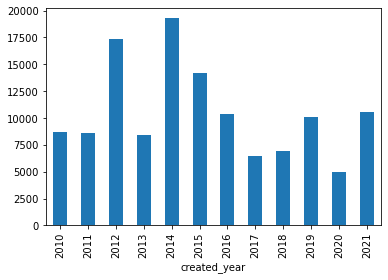

In [12]:
flood_gdf['created_year'] = pd.DatetimeIndex(flood_records['created_date']).year
flood_gdf.groupby('created_year')['unique_key'].count().plot.bar()

### Export

In [18]:
flood_gdf.to_file('processed_data/311_flooding.geojson', driver = 'GeoJSON')